In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, Input, Bidirectional, LSTM, TimeDistributed, RNN
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import shutil
import cv2
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/Dataset/dataset_tumor_otak.zip" -d "/content/dataset"

Archive:  /content/drive/MyDrive/Dataset/dataset_tumor_otak.zip
  inflating: /content/dataset/Testing/glioma_tumor/image(1).jpg  
  inflating: /content/dataset/Testing/glioma_tumor/image(10).jpg  
  inflating: /content/dataset/Testing/glioma_tumor/image(100).jpg  
  inflating: /content/dataset/Testing/glioma_tumor/image(11).jpg  
  inflating: /content/dataset/Testing/glioma_tumor/image(12).jpg  
  inflating: /content/dataset/Testing/glioma_tumor/image(13).jpg  
  inflating: /content/dataset/Testing/glioma_tumor/image(14).jpg  
  inflating: /content/dataset/Testing/glioma_tumor/image(15).jpg  
  inflating: /content/dataset/Testing/glioma_tumor/image(16).jpg  
  inflating: /content/dataset/Testing/glioma_tumor/image(17).jpg  
  inflating: /content/dataset/Testing/glioma_tumor/image(18).jpg  
  inflating: /content/dataset/Testing/glioma_tumor/image(19).jpg  
  inflating: /content/dataset/Testing/glioma_tumor/image(2).jpg  
  inflating: /content/dataset/Testing/glioma_tumor/image(20).jpg  

In [4]:
#create labels
classes=[]
filename='../content/dataset'
for sub_folder in os.listdir(os.path.join(filename,'Training')):
    classes.append(sub_folder)
print(classes)

['pituitary_tumor', 'glioma_tumor', 'no_tumor', 'meningioma_tumor']


In [5]:
X_train = []
y_train = []
image_size = 224
for i in classes:
    path_train = os.path.join(filename,'Training',i)
    for j in tqdm(os.listdir(path_train)): #Instantly make your loops show a smart progress meter 
        img = cv2.imread(os.path.join(path_train,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
    path_test = os.path.join(filename,'Testing',i)
    for j in tqdm(os.listdir(path_test)):
        img = cv2.imread(os.path.join(path_test,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)  

100%|██████████| 115/115 [00:00<00:00, 480.53it/s]


In [6]:
#data augmentation
X_train, y_train = shuffle(X_train,y_train, random_state=101)
datagen = ImageDataGenerator(
    rotation_range=7, #rotate images
    width_shift_range=0.05,
    height_shift_range=0.05, #shift image in horizontal and vertical
    zoom_range=0.15) #zoom images
    # horizontal_flip=True) 

datagen.fit(X_train)
X_train.shape
lb = LabelEncoder()

#train and test splitting 
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.10,random_state=101,stratify=y_train)

labels_train=lb.fit(y_train)
y_train=lb.transform(y_train)
y_test=lb.transform(y_test)

In [7]:
len(X_train)

2937

In [8]:
len(X_test)

327

##Resnet50

In [ ]:
model_resnet = Sequential(ResNet50(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3)))
model_resnet.add(Flatten())
tf.keras.applications.trainable = False
model_resnet.add(Dense(256, activation='relu'))
model_resnet.add(Dropout(0.5))
model_resnet.add(Dense(4, activation='softmax'))

In [ ]:
model_resnet.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 49,279,108
Trainable params: 49,225,988
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
opt = Adam(learning_rate=0.000016, beta_1=0.92, beta_2=0.9994, epsilon=1e-08)
model_resnet.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
historyresnet=model_resnet.fit(X_train ,y_train,
                         validation_data = (X_test,y_test),
                         epochs=30,
                         batch_size=16)

Epoch 1/30
184/184 [==============================] - 40s 185ms/step - loss: 0.7965 - accuracy: 0.7429 - val_loss: 0.6459 - val_accuracy: 0.7492
Epoch 2/30
184/184 [==============================] - 34s 184ms/step - loss: 0.1889 - accuracy: 0.9333 - val_loss: 0.6091 - val_accuracy: 0.7706
Epoch 3/30
184/184 [==============================] - 34s 182ms/step - loss: 0.0784 - accuracy: 0.9748 - val_loss: 0.2943 - val_accuracy: 0.8991
Epoch 4/30
184/184 [==============================] - 34s 182ms/step - loss: 0.0573 - accuracy: 0.9809 - val_loss: 0.2070 - val_accuracy: 0.9083
Epoch 5/30
184/184 [==============================] - 34s 183ms/step - loss: 0.0482 - accuracy: 0.9854 - val_loss: 0.1201 - val_accuracy: 0.9694
Epoch 6/30
184/184 [==============================] - 36s 195ms/step - loss: 0.0228 - accuracy: 0.9942 - val_loss: 0.1158 - val_accuracy: 0.9633
Epoch 7/30
184/184 [==============================] - 34s 184ms/step - loss: 0.0227 - accuracy: 0.9932 - val_loss: 0.1419 - val_ac

In [ ]:
model_resnet.evaluate(X_test, y_test)

11/11 [==============================] - 1s 90ms/step - loss: 0.1385 - accuracy: 0.9755


[0.13846324384212494, 0.9755351543426514]

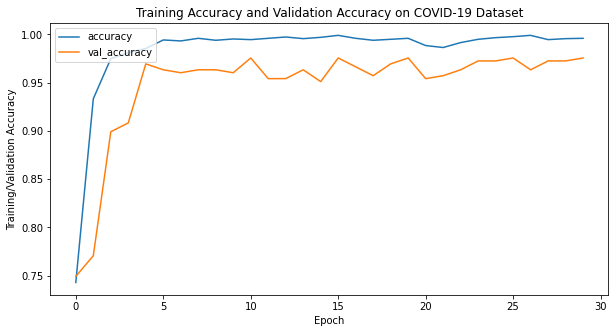

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(historyresnet.history["accuracy"], label = "accuracy")
plt.plot(historyresnet.history["val_accuracy"], label = "val_accuracy")
plt.title("Training Accuracy and Validation Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Accuracy")
plt.legend(loc = "upper left")

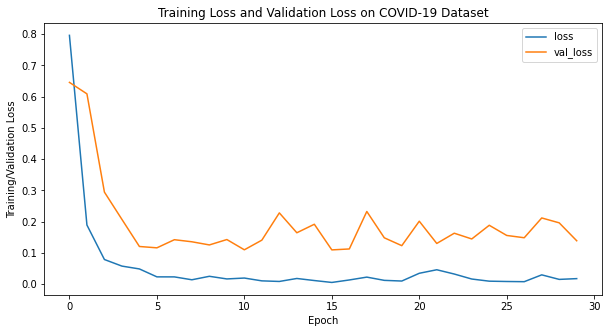

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(historyresnet.history["loss"], label = "loss")
plt.plot(historyresnet.history["val_loss"], label = "val_loss")
plt.title("Training Loss and Validation Loss on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Loss")
plt.legend()

In [ ]:
pred=np.argmax(model_resnet.predict(X_test),axis=1)
print(classification_report(y_test,pred,target_names=classes,digits=4))

                  precision    recall  f1-score   support

 pituitary_tumor     0.9783    0.9677    0.9730        93
        no_tumor     0.9783    0.9574    0.9677        94
meningioma_tumor     0.9608    0.9800    0.9703        50
    glioma_tumor     0.9783    1.0000    0.9890        90

        accuracy                         0.9755       327
       macro avg     0.9739    0.9763    0.9750       327
    weighted avg     0.9756    0.9755    0.9755       327



##Resnet50+BiLSTM

In [ ]:
model_resnetbilstm = Sequential(ResNet50(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3)))
model_resnetbilstm.add(TimeDistributed(Flatten()))
tf.keras.applications.trainable = False
model_resnetbilstm.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_resnetbilstm.add(Dropout(0.5))
model_resnetbilstm.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_resnetbilstm.add(Dropout(0.5))
model_resnetbilstm.add(Dense(256, activation='relu'))
model_resnetbilstm.add(Dense(4, activation='softmax'))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
model_resnetbilstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 time_distributed_1 (TimeDis  (None, 7, 14336)         0         
 tributed)                                                       
                                                                 
 bidirectional_2 (Bidirectio  (None, 7, 256)           14812160  
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 7, 256)            0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                      

In [ ]:
opt = Adam(learning_rate=0.000016, beta_1=0.92, beta_2=0.9994, epsilon=1e-08)
model_resnetbilstm.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history=model_resnetbilstm.fit(X_train ,y_train,
                               validation_data = (X_test,y_test),
                               epochs=30,
                               batch_size=16)
                               

Epoch 1/30
184/184 [==============================] - 51s 208ms/step - loss: 1.0413 - accuracy: 0.6299 - val_loss: 0.8976 - val_accuracy: 0.6422
Epoch 2/30
184/184 [==============================] - 34s 187ms/step - loss: 0.4742 - accuracy: 0.8737 - val_loss: 0.7355 - val_accuracy: 0.6972
Epoch 3/30
184/184 [==============================] - 35s 191ms/step - loss: 0.2224 - accuracy: 0.9472 - val_loss: 0.5125 - val_accuracy: 0.8043
Epoch 4/30
184/184 [==============================] - 35s 190ms/step - loss: 0.1071 - accuracy: 0.9768 - val_loss: 0.1846 - val_accuracy: 0.9419
Epoch 5/30
184/184 [==============================] - 35s 191ms/step - loss: 0.0553 - accuracy: 0.9894 - val_loss: 0.1079 - val_accuracy: 0.9633
Epoch 6/30
184/184 [==============================] - 35s 190ms/step - loss: 0.0345 - accuracy: 0.9942 - val_loss: 0.1215 - val_accuracy: 0.9664
Epoch 7/30
184/184 [==============================] - 35s 190ms/step - loss: 0.0241 - accuracy: 0.9966 - val_loss: 0.1275 - val_ac

In [ ]:
loss1, accuracy1 = model_resnetbilstm.evaluate(X_test, y_test)

11/11 [==============================] - 2s 91ms/step - loss: 0.1502 - accuracy: 0.9664


In [ ]:
print(f'accuracy : {round(accuracy1*100,3)} \n loss : {round(loss1,3)}')

accuracy : 96.636 
 loss : 0.15


<h2> Plot Accuracy dan Loss

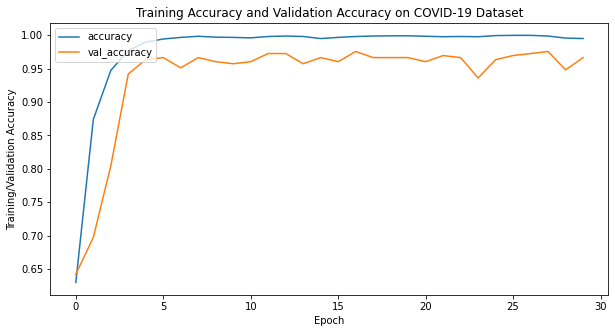

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(history.history["accuracy"], label = "accuracy")
plt.plot(history.history["val_accuracy"], label = "val_accuracy")
plt.title("Training Accuracy and Validation Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Accuracy")
plt.legend(loc = "upper left")

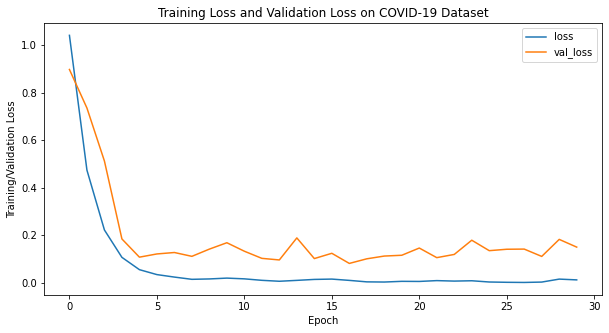

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.title("Training Loss and Validation Loss on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Loss")
plt.legend()

<h2> Save Model Resnet+BiLSTM

In [ ]:
model_resnetbilstm.save('/content/drive/MyDrive/Dataset/model_tumor_otak/model_resnet+bilstm_skripsi.h5')

In [ ]:
pred=np.argmax(model_resnetbilstm.predict(X_test),axis=1)
print(classification_report(y_test,pred,target_names=classes, digits=4))

                  precision    recall  f1-score   support

 pituitary_tumor     0.9889    0.9570    0.9727        93
        no_tumor     0.9479    0.9681    0.9579        94
meningioma_tumor     0.9583    0.9200    0.9388        50
    glioma_tumor     0.9677    1.0000    0.9836        90

        accuracy                         0.9664       327
       macro avg     0.9657    0.9613    0.9632       327
    weighted avg     0.9666    0.9664    0.9663       327



##VGG19

In [ ]:
model_vgg19 = Sequential(VGG19(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3)))
model_vgg19.add(Flatten())
tf.keras.applications.trainable = False
model_vgg19.add(Dense(256, activation='relu'))
model_vgg19.add(Dropout(0.5))
model_vgg19.add(Dense(4, activation='softmax'))

In [ ]:
model_vgg19.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 26,448,196
Trainable params: 26,448,196
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = Adam(learning_rate=0.000016, beta_1=0.92, beta_2=0.9994, epsilon=1e-08)
model_vgg19.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
historyvgg=model_vgg19.fit(X_train ,y_train,
                               validation_data = (X_test,y_test),
                               epochs=30,
                               batch_size=16)

Epoch 1/30
184/184 [==============================] - 52s 272ms/step - loss: 1.3670 - accuracy: 0.5672 - val_loss: 0.5167 - val_accuracy: 0.8012
Epoch 2/30
184/184 [==============================] - 50s 274ms/step - loss: 0.5221 - accuracy: 0.8090 - val_loss: 0.3115 - val_accuracy: 0.8930
Epoch 3/30
184/184 [==============================] - 50s 274ms/step - loss: 0.2964 - accuracy: 0.8897 - val_loss: 0.2829 - val_accuracy: 0.8991
Epoch 4/30
184/184 [==============================] - 50s 274ms/step - loss: 0.1972 - accuracy: 0.9288 - val_loss: 0.1548 - val_accuracy: 0.9450
Epoch 5/30
184/184 [==============================] - 50s 274ms/step - loss: 0.1386 - accuracy: 0.9530 - val_loss: 0.2096 - val_accuracy: 0.9144
Epoch 6/30
184/184 [==============================] - 50s 274ms/step - loss: 0.0982 - accuracy: 0.9646 - val_loss: 0.1038 - val_accuracy: 0.9633
Epoch 7/30
184/184 [==============================] - 50s 274ms/step - loss: 0.0561 - accuracy: 0.9806 - val_loss: 0.1184 - val_ac

In [ ]:
model_vgg19.evaluate(X_test, y_test)

11/11 [==============================] - 2s 165ms/step - loss: 0.0916 - accuracy: 0.9725


[0.09156610071659088, 0.9724770784378052]

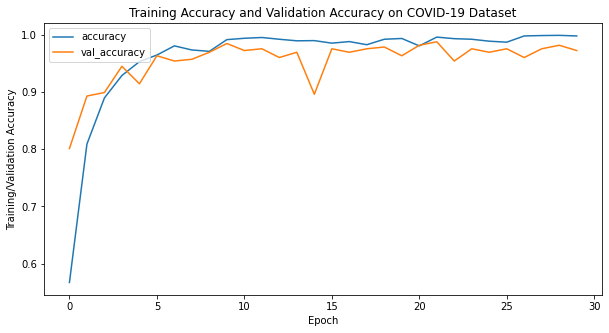

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(historyvgg.history["accuracy"], label = "accuracy")
plt.plot(historyvgg.history["val_accuracy"], label = "val_accuracy")
plt.title("Training Accuracy and Validation Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Accuracy")
plt.legend(loc = "upper left")

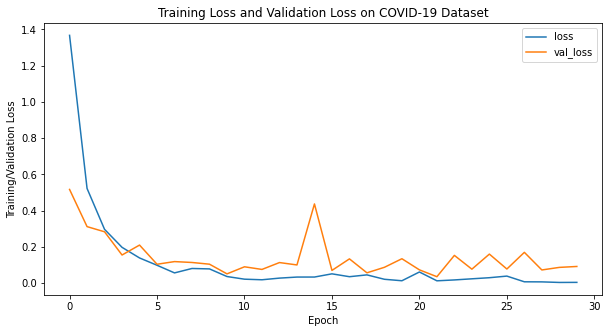

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(historyvgg.history["loss"], label = "loss")
plt.plot(historyvgg.history["val_loss"], label = "val_loss")
plt.title("Training Loss and Validation Loss on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Loss")
plt.legend()

In [ ]:
pred2=np.argmax(model_vgg19.predict(X_test),axis=1)
print(classification_report(y_test,pred2,target_names=classes,digits=4))

                  precision    recall  f1-score   support

 pituitary_tumor     0.9889    0.9570    0.9727        93
        no_tumor     0.9583    0.9787    0.9684        94
meningioma_tumor     1.0000    0.9400    0.9691        50
    glioma_tumor     0.9574    1.0000    0.9783        90

        accuracy                         0.9725       327
       macro avg     0.9762    0.9689    0.9721       327
    weighted avg     0.9732    0.9725    0.9724       327



##VGG19+BiLSTM baru

In [7]:
model_vgg19bilstm = Sequential(VGG19(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3)))
model_vgg19bilstm.add(TimeDistributed(Flatten()))
model_vgg19bilstm.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_vgg19bilstm.add(Dropout(0.5))
model_vgg19bilstm.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_vgg19bilstm.add(Dropout(0.5))
model_vgg19bilstm.add(Dense(256, activation='relu'))
model_vgg19bilstm.add(Dense(4, activation='softmax'))
tf.keras.applications.trainable = False

80150528/80134624 [==============================] - 1s 0us/step


In [8]:
model_vgg19bilstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 time_distributed (TimeDistr  (None, 7, 3584)          0         
 ibuted)                                                         
                                                                 
 bidirectional (Bidirectiona  (None, 7, 256)           3802112   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 7, 256)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                        

In [9]:
opt = Adam(learning_rate=0.000016, beta_1=0.92, beta_2=0.9994, epsilon=1e-08)
model_vgg19bilstm.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
history2=model_vgg19bilstm.fit(X_train ,y_train,
                               validation_data = (X_test,y_test),
                               epochs=30,
                               batch_size=16)

Epoch 1/30
184/184 [==============================] - 76s 292ms/step - loss: 1.2367 - accuracy: 0.4610 - val_loss: 1.0227 - val_accuracy: 0.6055
Epoch 2/30
184/184 [==============================] - 50s 272ms/step - loss: 0.9340 - accuracy: 0.6316 - val_loss: 0.6631 - val_accuracy: 0.7951
Epoch 3/30
184/184 [==============================] - 51s 276ms/step - loss: 0.6584 - accuracy: 0.7695 - val_loss: 0.4668 - val_accuracy: 0.8471
Epoch 4/30
184/184 [==============================] - 51s 280ms/step - loss: 0.4810 - accuracy: 0.8372 - val_loss: 0.3228 - val_accuracy: 0.8777
Epoch 5/30
184/184 [==============================] - 52s 282ms/step - loss: 0.3383 - accuracy: 0.9016 - val_loss: 0.1920 - val_accuracy: 0.9388
Epoch 6/30
184/184 [==============================] - 52s 284ms/step - loss: 0.2250 - accuracy: 0.9391 - val_loss: 0.1751 - val_accuracy: 0.9327
Epoch 7/30
184/184 [==============================] - 52s 285ms/step - loss: 0.1588 - accuracy: 0.9568 - val_loss: 0.1464 - val_ac

In [15]:
model_vgg19bilstm.evaluate(X_test, y_test)

11/11 [==============================] - 2s 162ms/step - loss: 0.0854 - accuracy: 0.9786


[0.08543296158313751, 0.9785932898521423]

<h2>Plot Accuracy dan Loss

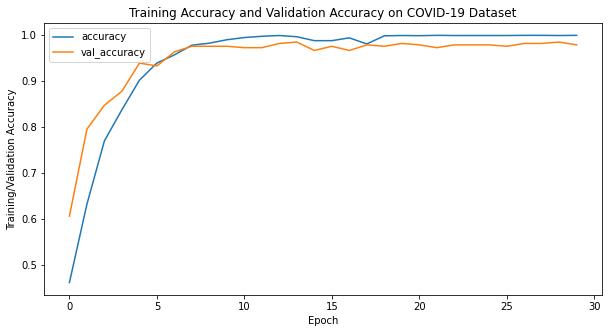

In [12]:
plt.figure(figsize = (10, 5))
plt.plot(history2.history["accuracy"], label = "accuracy")
plt.plot(history2.history["val_accuracy"], label = "val_accuracy")
plt.title("Training Accuracy and Validation Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Accuracy")
plt.legend(loc = "upper left")

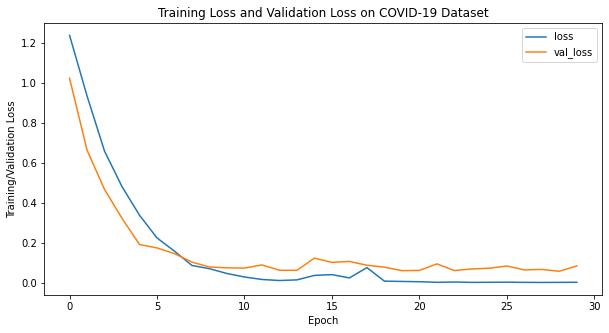

In [13]:
plt.figure(figsize = (10, 5))
plt.plot(history2.history["loss"], label = "loss")
plt.plot(history2.history["val_loss"], label = "val_loss")
plt.title("Training Loss and Validation Loss on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Loss")
plt.legend()

<h2>Save Model VGG19+BiLSTM

In [16]:
model_vgg19bilstm.save('/content/drive/MyDrive/Dataset/model_tumor_otak/model_vgg19+bilstm_skripsi_baru.h5')

In [ ]:
model_vgg19bilstm.save('/content/drive/MyDrive/Dataset/model_tumor_otak/model_vgg19+bilstm_percobaan1.h5')

In [14]:
pred2=np.argmax(model_vgg19bilstm.predict(X_test),axis=1)
print(classification_report(y_test,pred2,target_names=classes,digits=2+2))

                  precision    recall  f1-score   support

 pituitary_tumor     1.0000    0.9570    0.9780        93
    glioma_tumor     0.9490    0.9894    0.9688        94
        no_tumor     0.9804    1.0000    0.9901        50
meningioma_tumor     0.9888    0.9778    0.9832        90

        accuracy                         0.9786       327
       macro avg     0.9795    0.9810    0.9800       327
    weighted avg     0.9792    0.9786    0.9786       327



In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, pred2)

array([[172,   9,   3,   1],
       [  3, 178,   1,   6],
       [  1,   2,  95,   2],
       [  0,   0,   0, 180]])

##Xception

In [ ]:
model_xception = Sequential(Xception(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3)))
model_xception.add(Flatten())
tf.keras.applications.trainable = False
model_xception.add(Dense(256, activation='relu'))
model_xception.add(Dropout(0.5))
model_xception.add(Dense(4, activation='softmax'))

83697664/83683744 [==============================] - 0s 0us/step


In [ ]:
model_xception.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_8 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 46,552,876
Trainable params: 46,498,348
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
opt = Adam(learning_rate=0.000016, beta_1=0.92, beta_2=0.9994, epsilon=1e-08)
model_xception.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_xception=model_xception.fit(X_train ,y_train,
                               validation_data = (X_test,y_test),
                               epochs=30,
                               batch_size=16)

Epoch 1/30
184/184 [==============================] - 67s 329ms/step - loss: 0.7473 - accuracy: 0.7045 - val_loss: 0.4333 - val_accuracy: 0.8318
Epoch 2/30
184/184 [==============================] - 57s 308ms/step - loss: 0.2852 - accuracy: 0.8975 - val_loss: 0.2125 - val_accuracy: 0.9235
Epoch 3/30
184/184 [==============================] - 57s 310ms/step - loss: 0.1187 - accuracy: 0.9612 - val_loss: 0.1529 - val_accuracy: 0.9419
Epoch 4/30
184/184 [==============================] - 57s 308ms/step - loss: 0.0651 - accuracy: 0.9803 - val_loss: 0.1998 - val_accuracy: 0.9327
Epoch 5/30
184/184 [==============================] - 57s 310ms/step - loss: 0.0372 - accuracy: 0.9877 - val_loss: 0.1957 - val_accuracy: 0.9297
Epoch 6/30
184/184 [==============================] - 57s 309ms/step - loss: 0.0245 - accuracy: 0.9939 - val_loss: 0.1389 - val_accuracy: 0.9511
Epoch 7/30
184/184 [==============================] - 57s 309ms/step - loss: 0.0159 - accuracy: 0.9963 - val_loss: 0.1585 - val_ac

In [ ]:
model_xception.evaluate(X_test, y_test)

11/11 [==============================] - 2s 115ms/step - loss: 0.2326 - accuracy: 0.9664


[0.23258566856384277, 0.966360867023468]

<h2>Plot Accuracy dan Loss

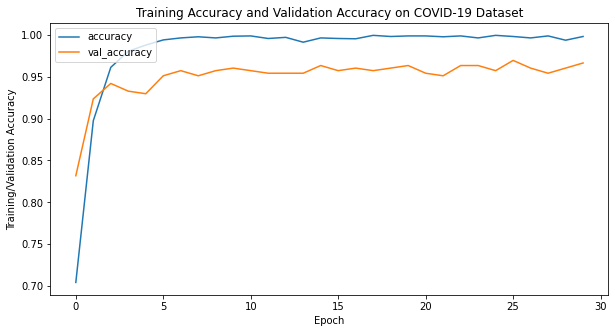

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(history_xception.history["accuracy"], label = "accuracy")
plt.plot(history_xception.history["val_accuracy"], label = "val_accuracy")
plt.title("Training Accuracy and Validation Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Accuracy")
plt.legend(loc = "upper left")

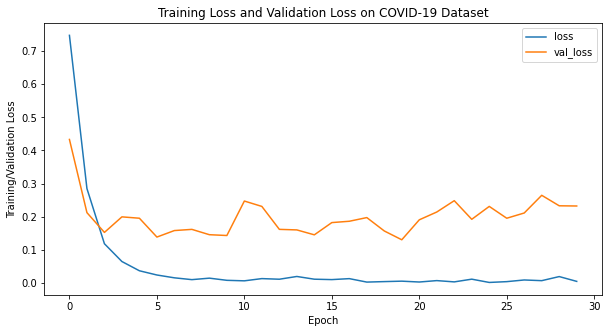

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(history_xception.history["loss"], label = "loss")
plt.plot(history_xception.history["val_loss"], label = "val_loss")
plt.title("Training Loss and Validation Loss on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Loss")
plt.legend()

In [ ]:
pred2=np.argmax(model_xception.predict(X_test),axis=1)
print(classification_report(y_test,pred2,target_names=classes, digits=4))

                  precision    recall  f1-score   support

 pituitary_tumor     0.9778    0.9462    0.9617        93
        no_tumor     0.9681    0.9681    0.9681        94
meningioma_tumor     0.9792    0.9400    0.9592        50
    glioma_tumor     0.9474    1.0000    0.9730        90

        accuracy                         0.9664       327
       macro avg     0.9681    0.9636    0.9655       327
    weighted avg     0.9668    0.9664    0.9663       327



##Xception+BiLSTM

In [ ]:
model_xceptionbilstm = Sequential(Xception(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3)))
model_xceptionbilstm.add(TimeDistributed(Flatten()))
model_xceptionbilstm.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_xceptionbilstm.add(Dropout(0.5))
model_xceptionbilstm.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_xceptionbilstm.add(Dropout(0.5))
model_xceptionbilstm.add(Dense(256, activation='relu'))
model_xceptionbilstm.add(Dense(4, activation='softmax'))
tf.keras.applications.trainable = False

In [ ]:
model_xceptionbilstm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 time_distributed_3 (TimeDis  (None, 7, 14336)         0         
 tributed)                                                       
                                                                 
 bidirectional_6 (Bidirectio  (None, 7, 256)           14812160  
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 7, 256)            0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                      

In [ ]:
opt = Adam(learning_rate=0.000016, beta_1=0.91, beta_2=0.9994, epsilon=1e-08)
model_xceptionbilstm.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history3=model_xceptionbilstm.fit(X_train ,y_train,
                               validation_data = (X_test,y_test),
                               epochs=30,
                               batch_size=16)

Epoch 1/30
184/184 [==============================] - 70s 328ms/step - loss: 1.0219 - accuracy: 0.6153 - val_loss: 0.5592 - val_accuracy: 0.7982
Epoch 2/30
184/184 [==============================] - 58s 314ms/step - loss: 0.4593 - accuracy: 0.8628 - val_loss: 0.2833 - val_accuracy: 0.9205
Epoch 3/30
184/184 [==============================] - 58s 314ms/step - loss: 0.1888 - accuracy: 0.9496 - val_loss: 0.1542 - val_accuracy: 0.9480
Epoch 4/30
184/184 [==============================] - 58s 315ms/step - loss: 0.0810 - accuracy: 0.9840 - val_loss: 0.1692 - val_accuracy: 0.9480
Epoch 5/30
184/184 [==============================] - 58s 314ms/step - loss: 0.0479 - accuracy: 0.9881 - val_loss: 0.1645 - val_accuracy: 0.9572
Epoch 6/30
184/184 [==============================] - 58s 314ms/step - loss: 0.0231 - accuracy: 0.9956 - val_loss: 0.1796 - val_accuracy: 0.9511
Epoch 7/30
184/184 [==============================] - 58s 314ms/step - loss: 0.0160 - accuracy: 0.9969 - val_loss: 0.1565 - val_ac

In [ ]:
model_xceptionbilstm.evaluate(X_test, y_test)

11/11 [==============================] - 1s 122ms/step - loss: 0.1846 - accuracy: 0.9633


[0.184580996632576, 0.963302731513977]

<h2>Plot Accuracy dan Loss

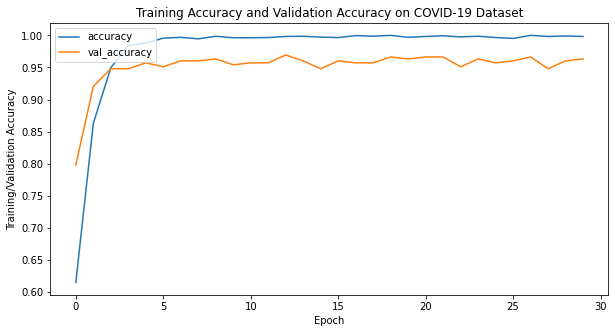

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(history3.history["accuracy"], label = "accuracy")
plt.plot(history3.history["val_accuracy"], label = "val_accuracy")
plt.title("Training Accuracy and Validation Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Accuracy")
plt.legend(loc = "upper left")

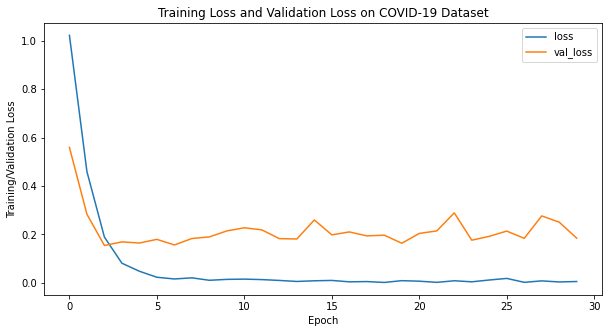

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(history3.history["loss"], label = "loss")
plt.plot(history3.history["val_loss"], label = "val_loss")
plt.title("Training Loss and Validation Loss on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Loss")
plt.legend()

<h2>Save Model Xception+BiLSTM

In [ ]:
model_xceptionbilstm.save('/content/drive/MyDrive/Dataset/model_tumor_otak/model_xception+bilstm_skripsi.h5')

In [ ]:
pred2=np.argmax(model_xceptionbilstm.predict(X_test),axis=1)
print(classification_report(y_test,pred2,target_names=classes,digits=4))

                  precision    recall  f1-score   support

 pituitary_tumor     0.9667    0.9355    0.9508        93
        no_tumor     0.9479    0.9681    0.9579        94
meningioma_tumor     0.9592    0.9400    0.9495        50
    glioma_tumor     0.9783    1.0000    0.9890        90

        accuracy                         0.9633       327
       macro avg     0.9630    0.9609    0.9618       327
    weighted avg     0.9633    0.9633    0.9632       327



##InceptionV3

In [17]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [18]:
model_inception = Sequential(InceptionV3(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3)))
model_inception.add(Flatten())
tf.keras.applications.trainable = False
model_inception.add(Dense(256, activation='relu'))
model_inception.add(Dropout(0.5))
model_inception.add(Dense(4, activation='softmax'))

87924736/87910968 [==============================] - 0s 0us/step


In [19]:
model_inception.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               13107456  
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 34,911,268
Trainable params: 34,876,836
Non-trainable params: 34,432
_________________________________________________________________


In [20]:
opt = Adam(learning_rate=0.000016, beta_1=0.91, beta_2=0.9994, epsilon=1e-08)
model_inception.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
history_inception=model_inception.fit(X_train ,y_train,
                               validation_data = (X_test,y_test),
                               epochs=30,
                               batch_size=16)

Epoch 1/30
184/184 [==============================] - 37s 153ms/step - loss: 0.9080 - accuracy: 0.6459 - val_loss: 0.4140 - val_accuracy: 0.8624
Epoch 2/30
184/184 [==============================] - 25s 136ms/step - loss: 0.3946 - accuracy: 0.8464 - val_loss: 0.2142 - val_accuracy: 0.9266
Epoch 3/30
184/184 [==============================] - 25s 135ms/step - loss: 0.2178 - accuracy: 0.9213 - val_loss: 0.1578 - val_accuracy: 0.9450
Epoch 4/30
184/184 [==============================] - 25s 136ms/step - loss: 0.1379 - accuracy: 0.9537 - val_loss: 0.1154 - val_accuracy: 0.9602
Epoch 5/30
184/184 [==============================] - 25s 136ms/step - loss: 0.0823 - accuracy: 0.9680 - val_loss: 0.1129 - val_accuracy: 0.9664
Epoch 6/30
184/184 [==============================] - 26s 140ms/step - loss: 0.0547 - accuracy: 0.9857 - val_loss: 0.1081 - val_accuracy: 0.9664
Epoch 7/30
184/184 [==============================] - 26s 141ms/step - loss: 0.0476 - accuracy: 0.9854 - val_loss: 0.1324 - val_ac

In [22]:
model_inception.evaluate(X_test, y_test)

11/11 [==============================] - 2s 67ms/step - loss: 0.2098 - accuracy: 0.9664


[0.209797203540802, 0.966360867023468]

<h2>Plot Accuracy dan Loss

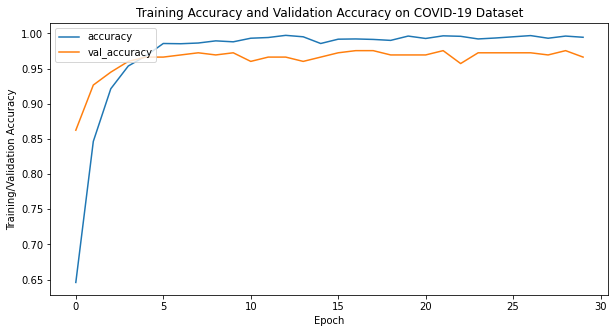

In [23]:
plt.figure(figsize = (10, 5))
plt.plot(history_inception.history["accuracy"], label = "accuracy")
plt.plot(history_inception.history["val_accuracy"], label = "val_accuracy")
plt.title("Training Accuracy and Validation Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Accuracy")
plt.legend(loc = "upper left")

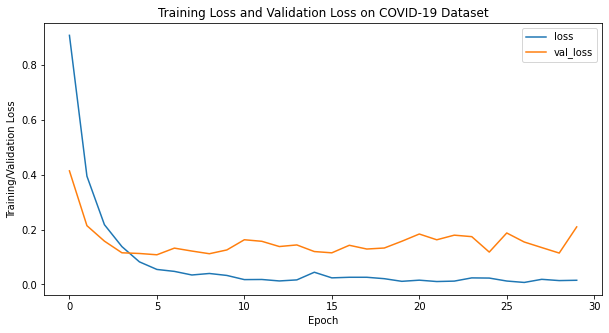

In [24]:
plt.figure(figsize = (10, 5))
plt.plot(history_inception.history["loss"], label = "loss")
plt.plot(history_inception.history["val_loss"], label = "val_loss")
plt.title("Training Loss and Validation Loss on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Loss")
plt.legend()

<h2>Save Model Xception+BiLSTM

In [29]:
pred2=np.argmax(model_inception.predict(X_test),axis=1)
print(classification_report(y_test,pred2,target_names=classes,digits=4
                            ))

                  precision    recall  f1-score   support

 pituitary_tumor     0.9681    0.9785    0.9733        93
    glioma_tumor     0.9888    0.9362    0.9617        94
        no_tumor     0.9259    1.0000    0.9615        50
meningioma_tumor     0.9667    0.9667    0.9667        90

        accuracy                         0.9664       327
       macro avg     0.9624    0.9703    0.9658       327
    weighted avg     0.9672    0.9664    0.9663       327



##InceptionV3+BiLSTM

In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [10]:
model_inceptionbilstm = Sequential(InceptionV3(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3)))
model_inceptionbilstm.add(TimeDistributed(Flatten()))
tf.keras.applications.trainable = False
model_inceptionbilstm.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_inceptionbilstm.add(Dropout(0.5))
model_inceptionbilstm.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_inceptionbilstm.add(Dropout(0.5))
model_inceptionbilstm.add(Dense(256, activation='relu'))
model_inceptionbilstm.add(Dense(4, activation='softmax'))

87924736/87910968 [==============================] - 0s 0us/step


In [11]:
model_inceptionbilstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 time_distributed (TimeDistr  (None, 5, 10240)         0         
 ibuted)                                                         
                                                                 
 bidirectional (Bidirectiona  (None, 5, 256)           10617856  
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 5, 256)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                        

In [12]:
opt = Adam(learning_rate=0.000016, beta_1=0.91, beta_2=0.9994, epsilon=1e-08)
model_inceptionbilstm.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
history_inceptionblstm=model_inceptionbilstm.fit(X_train ,y_train,
                               validation_data = (X_test,y_test),
                               epochs=20+10,
                               batch_size=16)

Epoch 1/30
184/184 [==============================] - 65s 188ms/step - loss: 1.1102 - accuracy: 0.5570 - val_loss: 0.6792 - val_accuracy: 0.8135
Epoch 2/30
184/184 [==============================] - 28s 152ms/step - loss: 0.5134 - accuracy: 0.8543 - val_loss: 0.2537 - val_accuracy: 0.9174
Epoch 3/30
184/184 [==============================] - 29s 157ms/step - loss: 0.2748 - accuracy: 0.9224 - val_loss: 0.1735 - val_accuracy: 0.9419
Epoch 4/30
184/184 [==============================] - 28s 154ms/step - loss: 0.1412 - accuracy: 0.9629 - val_loss: 0.1236 - val_accuracy: 0.9694
Epoch 5/30
184/184 [==============================] - 28s 155ms/step - loss: 0.0999 - accuracy: 0.9738 - val_loss: 0.1103 - val_accuracy: 0.9725
Epoch 6/30
184/184 [==============================] - 29s 157ms/step - loss: 0.0586 - accuracy: 0.9864 - val_loss: 0.1182 - val_accuracy: 0.9664
Epoch 7/30
184/184 [==============================] - 28s 154ms/step - loss: 0.0394 - accuracy: 0.9911 - val_loss: 0.0967 - val_ac

In [14]:
model_inceptionbilstm.evaluate(X_test, y_test)

11/11 [==============================] - 2s 71ms/step - loss: 0.1211 - accuracy: 0.9755


[0.12105190753936768, 0.9755351543426514]

<h2>Plot Accuracy dan Loss

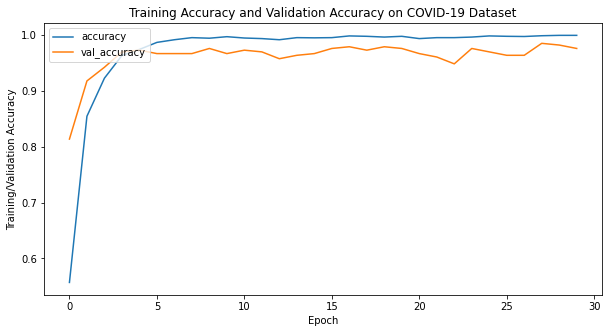

In [15]:
plt.figure(figsize = (10, 5))
plt.plot(history_inceptionblstm.history["accuracy"], label = "accuracy")
plt.plot(history_inceptionblstm.history["val_accuracy"], label = "val_accuracy")
plt.title("Training Accuracy and Validation Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Accuracy")
plt.legend(loc = "upper left")

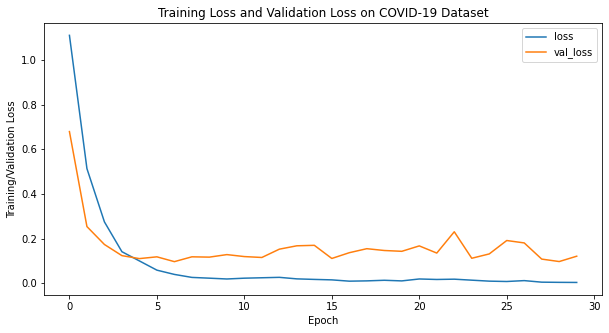

In [16]:
plt.figure(figsize = (10, 5))
plt.plot(history_inceptionblstm.history["loss"], label = "loss")
plt.plot(history_inceptionblstm.history["val_loss"], label = "val_loss")
plt.title("Training Loss and Validation Loss on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Loss")
plt.legend()

<h3>Classification Report Model Xception+BiLSTM

In [17]:
pred2=np.argmax(model_inceptionbilstm.predict(X_test),axis=1)
print(classification_report(y_test,pred2,target_names=classes, digits=2+2))

                  precision    recall  f1-score   support

 pituitary_tumor     0.9783    0.9677    0.9730        93
    glioma_tumor     0.9588    0.9894    0.9738        94
        no_tumor     0.9796    0.9600    0.9697        50
meningioma_tumor     0.9888    0.9778    0.9832        90

        accuracy                         0.9755       327
       macro avg     0.9763    0.9737    0.9749       327
    weighted avg     0.9758    0.9755    0.9755       327

